In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

# Random forests on mouse phenotype data

Today we will use one of the most popular supervised learning methods: random forests. It is an ensemble method, which means it uses multiple predictors and makes its final prediction based on a democratic vote of its individual predictors.

These sub-predictors are called decision trees, hence the name forest. Decision trees are labelled binary trees. Every leaf is associated with a class label, and every branching point is a test for a feature-value pair: if the feature is larger than the value, the sample is passed on towards the left branch, otherwise it continues on the right branch. The prediction is the label of the leaf it eventually reaches, starting from the tree's root.

Random forests generate a set of decision trees in a structured manner, and aggregate their results. Let's see

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image 
from sklearn import tree
from sklearn import metrics as sme

In [3]:
pheno = pd.read_csv('../example_data/phenotype_cd_hfd.csv', index_col=0)
target = pheno['diet'].replace('CD', 0).replace('HFD', 1)
data = pheno.dropna(axis=1).drop(columns=['strain', 'diet'])

### 1.1 Use a random forest classifier
Initialize it with default settings. Show its biased performance by fitting and predicting on the entire dataset, and then show its real accuracy using a proper cross-validation. For cross-validation, use the one-liner form with yesterday's convencience function.

Then try the same with standardized input data (no need to do it fold-by-fold), and report your findings.

In [161]:
# Random forest classifier
clf = RandomForestClassifier(random_state=0, n_estimators=10)
clf.fit(data, target)
clf.score(data, target)

# Cross validation
kf = StratifiedKFold(n_splits=3, shuffle=True)
cross_val_score(clf, data, target, cv=kf).mean()

# Standardized data
scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)
cross_val_score(clf, scaled, target, cv=kf).mean()

0.8496917970602181

### 1.1.2 Determine the uncertainty of the accuracy by bootstrapping
You must have noticed that the cross-validated accuracy of the model isn't exact: it depends on the particular folds that you get during cross-validation.
If you have `shuffling` enabled, your folds will be different each time. So by repeating cross-validation many times, you could get a clearer idea of the model's accuracy by taking the average, or better yet, looking at the distribution of the individual accuracy figures.

Use 100 repeats and plot the histogram of the resulting accuracy values. What is the 90% confidence interval of the model's accuracy? (What is a confidence interval to begin with?)

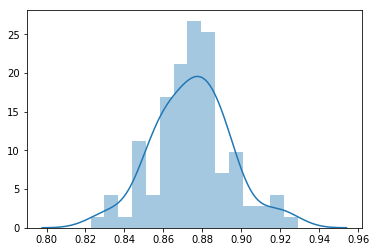

CONFIDENCE INTERVAL FROM 0.8483285917496443 TO 0.911130867709815


In [162]:
# Calculate Histogram and confidence interval
accuracies = []
for i in range(100):
    accuracies.append(cross_val_score(clf, scaled, target, cv=kf).mean())
    
# Lower and upper bound of interval
lower = np.percentile(accuracies, 5)
upper = np.percentile(accuracies, 95)

sns.distplot(accuracies, bins=15, hist=True)    
plt.show()
print('CONFIDENCE INTERVAL FROM', lower, "TO", upper)

### 1.2 Extract prediction probabilities instead of labels
`RandomForestClassifier`s have a `predict_proba` method by default, similar to `SVC`s with `proability=True` turned on. Use the convencience one-liner to get cross-validated class membership probability estimates for each sample. Create a histogram using the probability values for class `1`, but separate them by the true label of the samples, and color the two labels differently.

In [165]:
cv_probs = cross_val_predict(clf, data, target, cv=kf, method='predict_proba')
cv_probs = pd.DataFrame(cv_probs, index=target.index)
cv_probs

sns.distplot(cv_probs.loc[target==0,1])
sns.distplot(cv_probs.loc[target==1,1])

,0,1
0,1.0,0.0
1,0.8,0.2
2,0.4,0.6
3,0.1,0.9
4,0.9,0.1
5,0.4,0.6
6,1.0,0.0
7,0.0,1.0
8,0.8,0.2
9,0.7,0.3


### 1.2.2 Look at the numeric probability values. Why are they so rough?
Find out what they are derived from, and try to increase their resolution.

,0,1
0,1.0,0.0
1,0.9,0.1
2,0.7,0.3
3,0.0,1.0
4,1.0,0.0
5,0.0,1.0
6,0.8,0.2
7,0.1,0.9
8,1.0,0.0
9,0.9,0.1


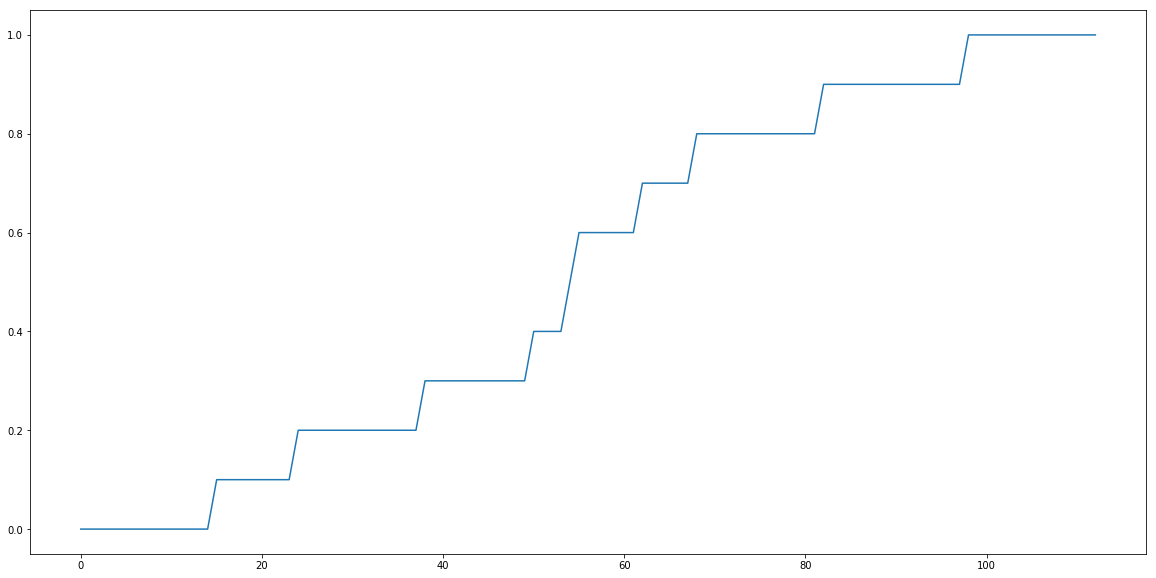

In [164]:
plt.figure(figsize=(20,10))
plt.plot(np.sort(cv_probs.loc[:,0]))
print(cv_probs)

# They are so rough because each forest "votes" for one class label and with default amount of trees
# of 10 you get those values

### 1.3 Create a ROC curve
Now that you know how to access the continuous internal prediction variables (class membership probability in this case) you can create a ROC plot easily.

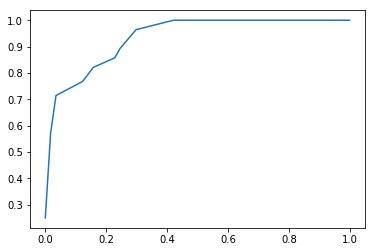

In [178]:
roc_results = sme.roc_curve(target, cv_probs.loc[:,1])
roc_curve = plt.plot(roc_results[0], roc_results[1])

### 1.4 Visualize a decision tree
Pick any decision tree from the random forest, export it in `DOT` format using `sklearn.tree.export_graphviz` and visualize it with an online tool.

In [174]:
dtree = DecisionTreeClassifier()
dtree.fit(data,target)

tree.export_graphviz(dtree, out_file='tree.dot')

# Created visualization with online viewer and saved png in files

### 1.5 Feature importances
Random forests utilize their internal structure not just to provide probability estimates, but also to estimate the importance of different features. How do you think it's done? Find a way to access the values, and present them on a bar plot, sorted by importance.

By the way, do you have to use cross-validation for feature importance estimates?

,0
2H_ColdTest_[°C],0.000000
Glucose60min_OGTT_[mg/dL],0.000000
Glucose45min_OGTT_[mg/dL],0.000000
Glucose15min_OGTT_[mg/dL],0.000000
5H_ColdTest_[°C],0.000000
OGTT_Homa_IR,0.000000
Decrease_3-6H_[%],0.000000
Dist_pre_[m],0.000000
Decrease_0-6H_[%],0.000000
epididymalWAT_[g],0.000000


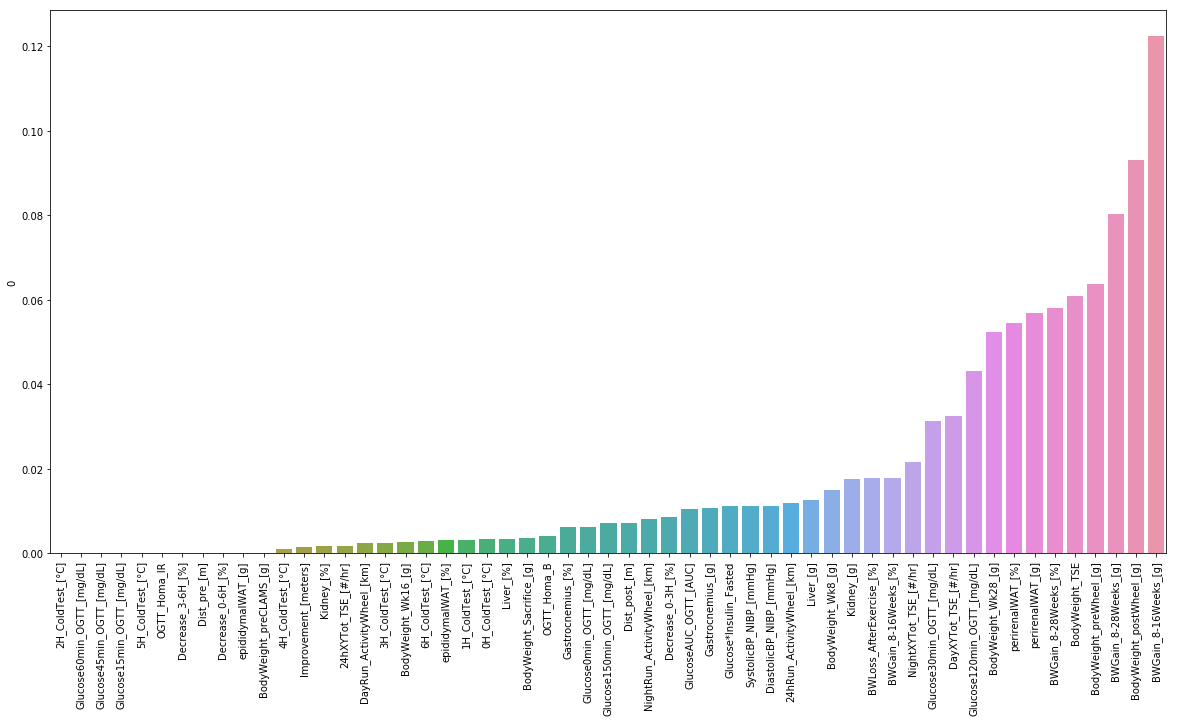

In [219]:
importances = clf.feature_importances_

import_frame = pd.DataFrame(importances, index=data.columns)
# import_frame['labels'] = data.columns

import_sort = import_frame.sort_values(0)

plt.figure(figsize=(20,10))
sns.barplot(import_sort.index, y = import_sort[0])
plt.xticks(rotation=90)

import_sort

### 1.6 Choose 3 features, and evaluate the model using only those features
Try to choose them with accuracy in mind. Treat it as a challenge: which 3 to choose to get the best model? What was your strategy?

In [222]:
keep_cols = ['BWGain_8-16Weeks_[g]', 'Glucose120min_OGTT_[mg/dL]', 'Kidney_[g]' ]

data_three = data.loc[:, keep_cols]

cross_val_score(clf, data_three, target, cv=kf)

array([0.89473684, 0.81578947, 0.78378378])

### 1.7 Feature clustering
Plot a clustermap of your data: it's not too big, 113x55 so you can keep all rows and columns and still have a readable figure with all feature labels if you increase its width a bit.

Should you plot the raw or the normalized data?

What patterns do you see? Are they relevant to the previous task?

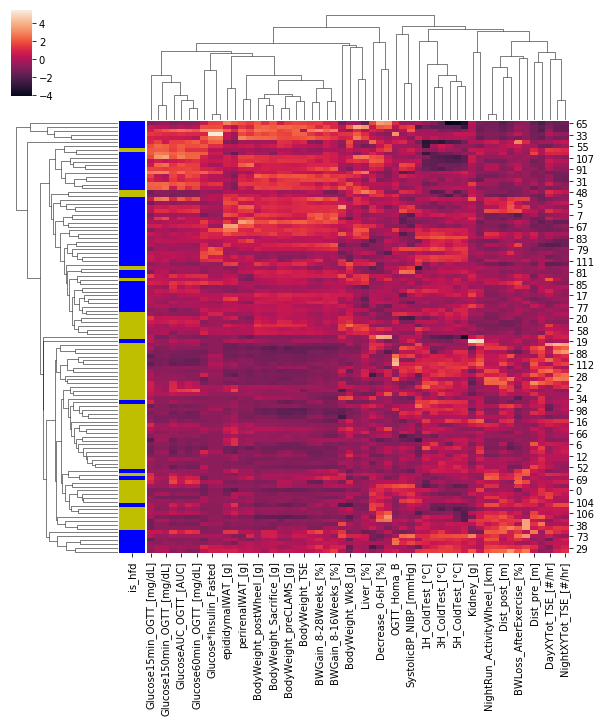

In [241]:
scaled_frame = pd.DataFrame(scaled, index=target.index, columns=data.columns)

# to color the labels
scaled_frame['is_hfd'] = target
scaled_frame['is_hfd'] = scaled_frame['is_hfd'].replace(True, "b")
scaled_frame['is_hfd'] = scaled_frame['is_hfd'].replace(False, "y")

# Plot clustermap
sns.clustermap(scaled_frame.iloc[:,:-1], row_colors=scaled_frame['is_hfd'])

### 1.7.2 Feature correlations
Calculate correlations between your features, and visualize them on a heatmap. Would it be useful to include the diet as an extra column?

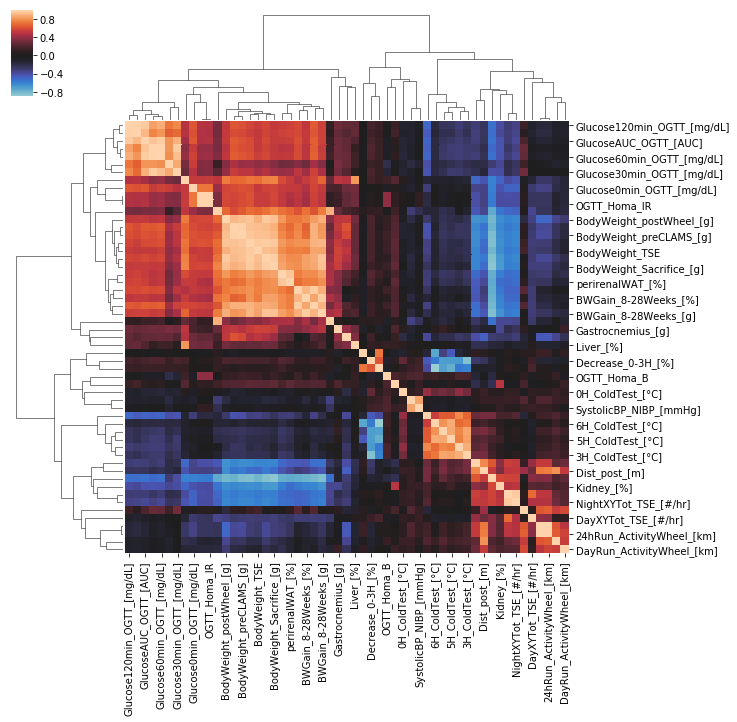

In [251]:
plt.figure(figsize=(20,15))
sns.clustermap(scaled_frame.iloc[:,:-1].corr(), center=0)